<a href="https://colab.research.google.com/github/NiliSoleil/MLP-Underfit-Overfit/blob/main/MLP_Underfit_Overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jun 13 16:35:23 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Imports 📢**

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 12.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from tqdm import tqdm
import csv

# **Dataset 🗂️**

## Read Dataset

In [ ]:
##read dataset
# !cp yourـdatasetـaddrres/shuttle.trn.Z /content/


In [ ]:
##uncompress
!uncompress /content/shuttle.trn.Z


In [ ]:
def read_file(file, phase):
    with open(file, 'rb') as fh:
      decompressed_data = fh.read()
    list_data = decompressed_data.decode('utf-8').splitlines()
    with open(phase +".csv","w", newline="") as f:
        writer = csv.writer(f)
        for line in list_data:
            # making cells by using , delimiters
            writer.writerow(line.split(" "))


In [ ]:
##readfile
read_file('shuttle.trn', "train")

train_dataset = pd.read_csv("/content/train.csv", header=None)

X = train_dataset.iloc[:, :-1].values
y = train_dataset.iloc[:, -1].values - 1

## Split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

## Preprocess

In [ ]:
# Convert to tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.LongTensor(y_valid)

# Standardization
mu = torch.mean(X_train, dim=0)
std = torch.std(X_train, dim=0)

X_train = (X_train - mu) / std
X_valid = (X_valid - mu) / std

## Dataloader

In [ ]:
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=128)

# **Model 🧠**

In [ ]:
def mlp_model():
  """Initializes multi layer perceptron model"""
  in_features = 9
  num_class = 7
  h1 = 64
  h2 = 32

  model = nn.Sequential(nn.Linear(in_features, h1),
                        nn.ReLU(),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        nn.Linear(h2, num_class))
  return model

model = mlp_model()
model


Sequential(
  (0): Linear(in_features=9, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=7, bias=True)
)

# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# **Loss ⚖️**

## CrossEntropyLoss

In [ ]:
loss_fn = nn.CrossEntropyLoss()

# **Optimizer📻**

## SGD

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=7).to(device)

  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())

      tepoch.set_postfix(loss=f'{loss_train.avg:.4f}',accuracy=f'{100.*acc_train.compute().item():.4f}')
  return model, loss_train.avg, acc_train.compute()

model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer)

100%|██████████| 476/476 [00:06<00:00, 77.49batch/s, accuracy=94.3941, loss=0.2346]


In [ ]:
def evaluate(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=7).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())

  return loss_valid.avg, acc_valid.compute()

evaluate(model, valid_loader, loss_fn)

(0.07205757027601495, tensor(0.9852, device='cuda:0'))

# **Efficient way to set hyperparams 🔨**

In [ ]:
model = mlp_model()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
x_batch, y_batch = next(iter(train_loader))

x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

outputs = model(x_batch)

loss_fn(outputs, y_batch)

tensor(2.0352, device='cuda:0', grad_fn=<NllLossBackward0>)

## Step 2: check backward path

Select 5 random batches and overfit the model

In [ ]:
mini_train_dataset, _ = random_split(train_data, (1000, (len(train_data)-1000)))
mini_loader = DataLoader(mini_train_dataset, batch_size=200, shuffle=True)

In [ ]:
for epoch in range(10):
  model, _, _ = train_one_epoch(model, mini_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 111.92batch/s, accuracy=77.1000, loss=1.6682]


## Step 3: select best lr

Train all data for one epoch

In [ ]:
for lr in [0.1, 0.01, 0.001, 0.0001]:

  print(f'lr={lr}')

  model = mlp_model()
  model = model.to(device)

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

  model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer)

  print()

lr=0.1


100%|██████████| 476/476 [00:02<00:00, 160.75batch/s, accuracy=95.4450, loss=0.1913]



lr=0.01


100%|██████████| 476/476 [00:02<00:00, 161.52batch/s, accuracy=78.0985, loss=0.7465]



lr=0.001


100%|██████████| 476/476 [00:04<00:00, 96.45batch/s, accuracy=66.4368, loss=1.7405]



lr=0.0001


100%|██████████| 476/476 [00:03<00:00, 144.56batch/s, accuracy=2.8637, loss=1.8871]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
from prettytable import PrettyTable

my_table = PrettyTable(["Learning Rate", "Weight decay", "accuracy", "loss"])


for lr in [0.1, 0.15, 0.20, 0.25]:
  for wd in [0., 1e-4, 1e-5, 1e-6]:

    model = mlp_model()
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    print(f'LR={lr}, WD={wd}')
    for epoch in range(5):
      model, loss, accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

      if epoch == 4:
        my_table.add_row([lr, wd, f'{100.*accuracy:.4f}', f'{loss:.4f}'])

    print()

  my_table.add_row([20*'-', 20*'-', 20*'-', 20*'-'])

print(my_table)

LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 134.54batch/s, accuracy=99.4384, loss=0.0367]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 130.92batch/s, accuracy=99.5041, loss=0.0315]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 119.40batch/s, accuracy=99.4417, loss=0.0339]



LR=0.1, WD=1e-06


Epoch 4: 100%|██████████| 476/476 [00:04<00:00, 95.65batch/s, accuracy=99.4483, loss=0.0348]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 476/476 [00:04<00:00, 95.64batch/s, accuracy=99.5271, loss=0.0242]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 122.49batch/s, accuracy=99.4089, loss=0.0282]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 129.61batch/s, accuracy=99.5205, loss=0.0281]



LR=0.15, WD=1e-06


Epoch 4: 100%|██████████| 476/476 [00:04<00:00, 109.03batch/s, accuracy=99.4614, loss=0.0282]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 476/476 [00:04<00:00, 97.06batch/s, accuracy=99.5041, loss=0.0264]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 131.67batch/s, accuracy=99.4910, loss=0.0245]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 476/476 [00:04<00:00, 116.64batch/s, accuracy=99.5534, loss=0.0213]



LR=0.2, WD=1e-06


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 122.61batch/s, accuracy=99.5534, loss=0.0241]



LR=0.25, WD=0.0


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 132.63batch/s, accuracy=99.5501, loss=0.0213]



LR=0.25, WD=0.0001


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 129.61batch/s, accuracy=99.6223, loss=0.0200]



LR=0.25, WD=1e-05


Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 120.53batch/s, accuracy=99.5566, loss=0.0233]



LR=0.25, WD=1e-06


Epoch 4: 100%|██████████| 476/476 [00:04<00:00, 117.10batch/s, accuracy=99.5895, loss=0.0211]



+----------------------+----------------------+----------------------+----------------------+
|    Learning Rate     |     Weight decay     |       accuracy       |         loss         |
+----------------------+----------------------+----------------------+----------------------+
|         0.1          |         0.0          |       99.4384        |        0.0367        |
|         0.1          |        0.0001        |       99.5041        |        0.0315        |
|         0.1          |        1e-05         |       99.4417        |        0.0339        |
|         0.1          |        1e-06         |       99.4483        |        0.0348        |
| -------------------- | -------------------- | -------------------- | -------------------- |
|         0.15         |         0.0          |       99.5271        |        0.0242        |
|         0.15         |        0.0001        |       99.4089        |        0.0282        |
|         0.15         |        1e-05         |       99.52

## Step 5: train more epochs

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_valid_loss = torch.inf
total_epochs = 0

In [ ]:
model = mlp_model()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.25, weight_decay=1e-04)

In [ ]:
num_epochs = 30


for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

  # Validation
  loss_valid, acc_valid = evaluate(model, valid_loader, loss_fn)

  if loss_valid < best_valid_loss:
    torch.save(model.state_dict(), '/content/best-model.pt')
    best_valid_loss = loss_valid

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train.cpu())
  acc_valid_hist.append(acc_valid.cpu())

  print(f'Valid: Loss = {loss_valid:.4}, Accuracy = {100.*acc_valid:.4f}\n')
  total_epochs += 1

Epoch 0: 100%|██████████| 476/476 [00:03<00:00, 129.06batch/s, accuracy=97.0739, loss=0.1403]


Valid: Loss = 0.07473, Accuracy = 98.8199



Epoch 1: 100%|██████████| 476/476 [00:03<00:00, 130.64batch/s, accuracy=99.2315, loss=0.0493]


Valid: Loss = 0.03035, Accuracy = 99.5326



Epoch 2: 100%|██████████| 476/476 [00:03<00:00, 120.45batch/s, accuracy=99.3695, loss=0.0331]


Valid: Loss = 0.02477, Accuracy = 99.4943



Epoch 3: 100%|██████████| 476/476 [00:03<00:00, 122.00batch/s, accuracy=99.4384, loss=0.0256]


Valid: Loss = 0.03158, Accuracy = 99.0651



Epoch 4: 100%|██████████| 476/476 [00:03<00:00, 134.54batch/s, accuracy=99.5041, loss=0.0235]


Valid: Loss = 0.02127, Accuracy = 99.6552



Epoch 5: 100%|██████████| 476/476 [00:03<00:00, 132.57batch/s, accuracy=99.5796, loss=0.0192]


Valid: Loss = 0.02186, Accuracy = 99.6398



Epoch 6: 100%|██████████| 476/476 [00:06<00:00, 75.24batch/s, accuracy=99.5961, loss=0.0174]


Valid: Loss = 0.01454, Accuracy = 99.7088



Epoch 7: 100%|██████████| 476/476 [00:03<00:00, 131.25batch/s, accuracy=99.6683, loss=0.0141]


Valid: Loss = 0.01564, Accuracy = 99.6858



Epoch 8: 100%|██████████| 476/476 [00:03<00:00, 133.65batch/s, accuracy=99.6946, loss=0.0125]


Valid: Loss = 0.01097, Accuracy = 99.7471



Epoch 9: 100%|██████████| 476/476 [00:04<00:00, 114.11batch/s, accuracy=99.7406, loss=0.0117]


Valid: Loss = 0.01042, Accuracy = 99.7471



Epoch 10: 100%|██████████| 476/476 [00:04<00:00, 108.22batch/s, accuracy=99.7438, loss=0.0110]


Valid: Loss = 0.01069, Accuracy = 99.7701



Epoch 11: 100%|██████████| 476/476 [00:04<00:00, 115.75batch/s, accuracy=99.7438, loss=0.0091]


Valid: Loss = 0.008962, Accuracy = 99.7854



Epoch 12: 100%|██████████| 476/476 [00:03<00:00, 125.92batch/s, accuracy=99.7734, loss=0.0106]


Valid: Loss = 0.01286, Accuracy = 99.7395



Epoch 13: 100%|██████████| 476/476 [00:04<00:00, 116.96batch/s, accuracy=99.7767, loss=0.0100]


Valid: Loss = 0.007814, Accuracy = 99.7854



Epoch 14: 100%|██████████| 476/476 [00:03<00:00, 119.34batch/s, accuracy=99.7997, loss=0.0098]


Valid: Loss = 0.00707, Accuracy = 99.7778



Epoch 15: 100%|██████████| 476/476 [00:03<00:00, 126.65batch/s, accuracy=99.7898, loss=0.0081]


Valid: Loss = 0.009157, Accuracy = 99.8084



Epoch 16: 100%|██████████| 476/476 [00:03<00:00, 123.73batch/s, accuracy=99.8325, loss=0.0080]


Valid: Loss = 0.02782, Accuracy = 99.5249



Epoch 17: 100%|██████████| 476/476 [00:03<00:00, 124.21batch/s, accuracy=99.8555, loss=0.0060]


Valid: Loss = 0.006202, Accuracy = 99.8238



Epoch 18: 100%|██████████| 476/476 [00:03<00:00, 123.09batch/s, accuracy=99.8161, loss=0.0075]


Valid: Loss = 0.007291, Accuracy = 99.8084



Epoch 19: 100%|██████████| 476/476 [00:03<00:00, 127.24batch/s, accuracy=99.8456, loss=0.0056]


Valid: Loss = 0.006753, Accuracy = 99.8008



Epoch 20: 100%|██████████| 476/476 [00:03<00:00, 122.45batch/s, accuracy=99.7997, loss=0.0068]


Valid: Loss = 0.008086, Accuracy = 99.8008



Epoch 21: 100%|██████████| 476/476 [00:03<00:00, 119.63batch/s, accuracy=99.8588, loss=0.0066]


Valid: Loss = 0.005158, Accuracy = 99.8467



Epoch 22: 100%|██████████| 476/476 [00:03<00:00, 127.49batch/s, accuracy=99.8719, loss=0.0055]


Valid: Loss = 0.00592, Accuracy = 99.7854



Epoch 23: 100%|██████████| 476/476 [00:03<00:00, 126.85batch/s, accuracy=99.8555, loss=0.0051]


Valid: Loss = 0.006063, Accuracy = 99.8238



Epoch 24: 100%|██████████| 476/476 [00:03<00:00, 126.87batch/s, accuracy=99.8588, loss=0.0057]


Valid: Loss = 0.004905, Accuracy = 99.8621



Epoch 25: 100%|██████████| 476/476 [00:04<00:00, 112.74batch/s, accuracy=99.8391, loss=0.0053]


Valid: Loss = 0.005577, Accuracy = 99.8621



Epoch 26: 100%|██████████| 476/476 [00:03<00:00, 128.58batch/s, accuracy=99.8489, loss=0.0052]


Valid: Loss = 0.005557, Accuracy = 99.8467



Epoch 27: 100%|██████████| 476/476 [00:03<00:00, 128.78batch/s, accuracy=99.8916, loss=0.0040]


Valid: Loss = 0.004493, Accuracy = 99.8544



Epoch 28: 100%|██████████| 476/476 [00:03<00:00, 120.97batch/s, accuracy=99.8489, loss=0.0065]


Valid: Loss = 0.006197, Accuracy = 99.8161



Epoch 29: 100%|██████████| 476/476 [00:04<00:00, 112.52batch/s, accuracy=99.8686, loss=0.0058]


Valid: Loss = 0.006643, Accuracy = 99.8314



# **Plot📉**

### Loss

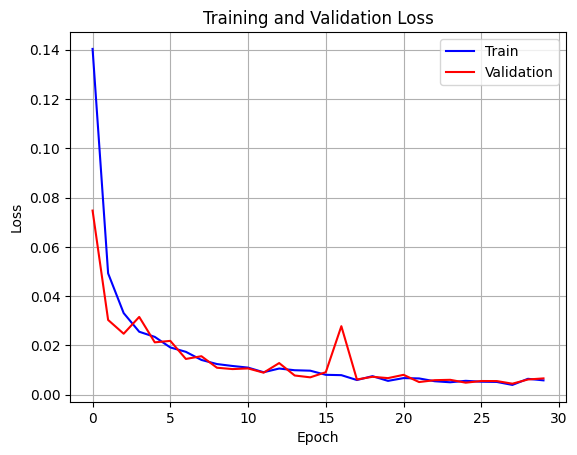

In [ ]:
# plot loss_epoch
plt.plot(range(total_epochs), loss_train_hist, 'b-', label="Train")
plt.plot(range(total_epochs), loss_valid_hist, 'r-', label="Validation")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Good fit model

### Accuracy

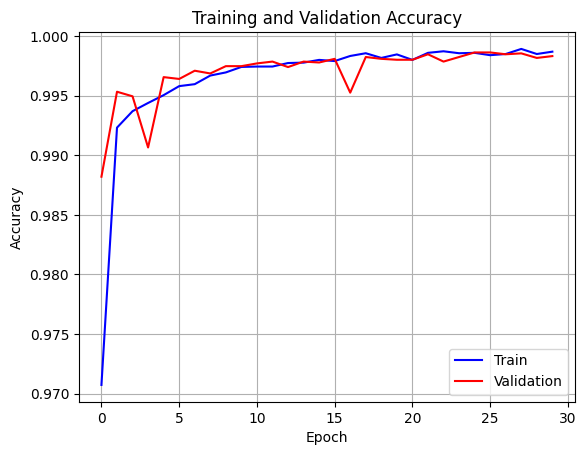

In [ ]:
# plot acc_epoch
plt.plot(range(total_epochs), acc_train_hist, 'b-', label="Train")
plt.plot(range(total_epochs), acc_valid_hist, 'r-', label="Validation")

plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# **Save & Prediction🔎**

**Using "Test" Data without "Labels" to Predict labels**



In [ ]:
df_test = pd.read_csv('/content/shuttledata_test.csv', header=None)
X_test = df_test.values

# Convert to tensor
X_test = torch.FloatTensor(X_test)

# Standardization
X_test = (X_test - mu) / std

In [ ]:
# Compute predicted outputs
test_preds = []

# Load the model with Lowest Validation Loss (best model)
model = mlp_model()
state_dict = torch.load('/content/best-model.pt')
model.load_state_dict(state_dict)
model = model.to(device)

with torch.no_grad():
  for inputs in X_test:
    inputs = inputs.to(device)
    test_pred = model(inputs)
    test_preds.append(test_pred.argmax().item() + 1) # class from 1 to 7

# Save Prediction to CSV file
header_list = ['pred']
pd.DataFrame(test_preds).to_csv('/content/predictions.csv', header=header_list, index=False)


To realize whether the labels have been predicted correctly, we need to compare the predicted values with the ground truth targets in Test Data.

In [ ]:
main_test = pd.read_csv('/content/full_test_homework_5.csv',header=None).values
pred = main_test[:,-1]
pred_va = pd.read_csv('/content/predictions.csv').values
pred_vali = pred_va[:,-1]
import numpy as np

acc_test = 100. * np.sum(pred == pred_vali)/len(pred)
print(acc_test)

99.8344827586207


# **Overfitting (using Dropout Technique)🌟**

In [ ]:
# Subset of Train Dataset
num_data = int(0.3 * len(train_dataset)) # select 30 percent of dataset =  13050 sample
subset_train_dataset, _ = random_split(train_dataset, (num_data, len(train_dataset)-num_data))
X_subset = X[subset_train_dataset.indices]
y_subset = y[subset_train_dataset.indices]

# Split
X_subset_train, X_subset_valid, y_subset_train, y_subset_valid = train_test_split(X_subset, y_subset, train_size=0.7, random_state=42)

# Convert to tensor
X_subset_train = torch.FloatTensor(X_subset_train)
y_subset_train = torch.LongTensor(y_subset_train)

X_subset_valid = torch.FloatTensor(X_subset_valid)
y_subset_valid = torch.LongTensor(y_subset_valid)

# Standardization
mu = torch.mean(X_subset_train, dim=0)
std = torch.std(X_subset_train, dim=0)

X_subset_train = (X_subset_train - mu) / std
X_subset_valid = (X_subset_valid - mu) / std

In [ ]:
def mlp():
  """Initializes multi layer perceptron model"""
  in_features = 9
  num_class = 7
  h1 = 1024
  h2 = 512
  h3 = 256

  model = nn.Sequential(nn.Linear(in_features, h1),
                        nn.ReLU(),
                        #nn.Dropout(p=0.5),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        #nn.Dropout(p=0.5),
                        nn.Linear(h2, h3),
                        nn.ReLU(),
                        #nn.Dropout(p=0.5),
                        nn.Linear(h3, num_class))
  return model
################################################################################

total_epochs = 0
loss_subset_train_hist = []
loss_subset_valid_hist = []

acc_subset_train_hist = []
acc_subset_valid_hist = []

model = mlp()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-04, momentum=0.9, nesterov=True)


In [ ]:
num_epochs = 60

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

  # Validation
  loss_valid, acc_valid = evaluate(model, valid_loader, loss_fn)

  loss_subset_train_hist.append(loss_train)
  loss_subset_valid_hist.append(loss_valid)

  acc_subset_train_hist.append(acc_train.cpu())
  acc_subset_valid_hist.append(acc_valid.cpu())

  print(f'Valid: Loss = {loss_valid:.4}, Accuracy = {100.*acc_valid:.4f}\n')
  total_epochs += 1

Epoch 0: 100%|██████████| 476/476 [00:04<00:00, 111.52batch/s, accuracy=97.0542, loss=0.1524]


Valid: Loss = 0.03677, Accuracy = 99.4330



Epoch 1: 100%|██████████| 476/476 [00:03<00:00, 121.39batch/s, accuracy=99.3136, loss=0.0366]


Valid: Loss = 0.02682, Accuracy = 99.5479



Epoch 2: 100%|██████████| 476/476 [00:03<00:00, 130.31batch/s, accuracy=99.4943, loss=0.0254]


Valid: Loss = 0.02186, Accuracy = 99.5249



Epoch 3: 100%|██████████| 476/476 [00:03<00:00, 127.67batch/s, accuracy=99.5107, loss=0.0211]


Valid: Loss = 0.01761, Accuracy = 99.6705



Epoch 4: 100%|██████████| 476/476 [00:04<00:00, 113.66batch/s, accuracy=99.6125, loss=0.0167]


Valid: Loss = 0.01409, Accuracy = 99.7165



Epoch 5: 100%|██████████| 476/476 [00:05<00:00, 92.03batch/s, accuracy=99.6585, loss=0.0142]


Valid: Loss = 0.01674, Accuracy = 99.6552



Epoch 6: 100%|██████████| 476/476 [00:04<00:00, 97.52batch/s, accuracy=99.6913, loss=0.0126]


Valid: Loss = 0.01037, Accuracy = 99.7395



Epoch 7: 100%|██████████| 476/476 [00:04<00:00, 105.74batch/s, accuracy=99.6979, loss=0.0112]


Valid: Loss = 0.01282, Accuracy = 99.7241



Epoch 8: 100%|██████████| 476/476 [00:03<00:00, 125.83batch/s, accuracy=99.7471, loss=0.0095]


Valid: Loss = 0.008599, Accuracy = 99.7625



Epoch 9: 100%|██████████| 476/476 [00:03<00:00, 128.18batch/s, accuracy=99.7701, loss=0.0091]


Valid: Loss = 0.01217, Accuracy = 99.6858



Epoch 10: 100%|██████████| 476/476 [00:03<00:00, 119.83batch/s, accuracy=99.7635, loss=0.0082]


Valid: Loss = 0.01484, Accuracy = 99.7241



Epoch 11: 100%|██████████| 476/476 [00:04<00:00, 117.19batch/s, accuracy=99.7800, loss=0.0071]


Valid: Loss = 0.007907, Accuracy = 99.7625



Epoch 12: 100%|██████████| 476/476 [00:03<00:00, 127.29batch/s, accuracy=99.8095, loss=0.0061]


Valid: Loss = 0.009303, Accuracy = 99.7778



Epoch 13: 100%|██████████| 476/476 [00:03<00:00, 127.10batch/s, accuracy=99.8292, loss=0.0062]


Valid: Loss = 0.01054, Accuracy = 99.7854



Epoch 14: 100%|██████████| 476/476 [00:04<00:00, 117.43batch/s, accuracy=99.8227, loss=0.0060]


Valid: Loss = 0.007107, Accuracy = 99.8008



Epoch 15: 100%|██████████| 476/476 [00:05<00:00, 92.96batch/s, accuracy=99.8424, loss=0.0054] 


Valid: Loss = 0.007383, Accuracy = 99.8008



Epoch 16: 100%|██████████| 476/476 [00:03<00:00, 127.60batch/s, accuracy=99.8456, loss=0.0048]


Valid: Loss = 0.007302, Accuracy = 99.7701



Epoch 17: 100%|██████████| 476/476 [00:03<00:00, 123.64batch/s, accuracy=99.8654, loss=0.0050]


Valid: Loss = 0.004423, Accuracy = 99.8774



Epoch 18: 100%|██████████| 476/476 [00:04<00:00, 112.01batch/s, accuracy=99.8719, loss=0.0043]


Valid: Loss = 0.005723, Accuracy = 99.8697



Epoch 19: 100%|██████████| 476/476 [00:03<00:00, 123.73batch/s, accuracy=99.8555, loss=0.0042]


Valid: Loss = 0.005423, Accuracy = 99.8391



Epoch 20: 100%|██████████| 476/476 [00:03<00:00, 124.74batch/s, accuracy=99.8719, loss=0.0036]


Valid: Loss = 0.004471, Accuracy = 99.8621



Epoch 21: 100%|██████████| 476/476 [00:04<00:00, 118.34batch/s, accuracy=99.8949, loss=0.0035]


Valid: Loss = 0.006137, Accuracy = 99.8467



Epoch 22: 100%|██████████| 476/476 [00:04<00:00, 112.23batch/s, accuracy=99.8916, loss=0.0040]


Valid: Loss = 0.00755, Accuracy = 99.7931



Epoch 23: 100%|██████████| 476/476 [00:03<00:00, 127.71batch/s, accuracy=99.8719, loss=0.0044]


Valid: Loss = 0.006493, Accuracy = 99.8467



Epoch 24: 100%|██████████| 476/476 [00:03<00:00, 127.09batch/s, accuracy=99.8916, loss=0.0039]


Valid: Loss = 0.005827, Accuracy = 99.8697



Epoch 25: 100%|██████████| 476/476 [00:04<00:00, 115.61batch/s, accuracy=99.9048, loss=0.0033]


Valid: Loss = 0.006212, Accuracy = 99.8161



Epoch 26: 100%|██████████| 476/476 [00:04<00:00, 113.82batch/s, accuracy=99.9278, loss=0.0031]


Valid: Loss = 0.004479, Accuracy = 99.8544



Epoch 27: 100%|██████████| 476/476 [00:03<00:00, 126.09batch/s, accuracy=99.8949, loss=0.0032]


Valid: Loss = 0.004023, Accuracy = 99.9004



Epoch 28: 100%|██████████| 476/476 [00:03<00:00, 125.51batch/s, accuracy=99.8916, loss=0.0044]


Valid: Loss = 0.005946, Accuracy = 99.8544



Epoch 29: 100%|██████████| 476/476 [00:04<00:00, 115.53batch/s, accuracy=99.9015, loss=0.0034]


Valid: Loss = 0.004699, Accuracy = 99.8467



Epoch 30: 100%|██████████| 476/476 [00:04<00:00, 114.92batch/s, accuracy=99.9179, loss=0.0027]


Valid: Loss = 0.003646, Accuracy = 99.8851



Epoch 31: 100%|██████████| 476/476 [00:03<00:00, 126.07batch/s, accuracy=99.9310, loss=0.0028]


Valid: Loss = 0.004704, Accuracy = 99.8774



Epoch 32: 100%|██████████| 476/476 [00:03<00:00, 120.14batch/s, accuracy=99.9343, loss=0.0024]


Valid: Loss = 0.003372, Accuracy = 99.8774



Epoch 33: 100%|██████████| 476/476 [00:03<00:00, 120.51batch/s, accuracy=99.9179, loss=0.0029]


Valid: Loss = 0.004141, Accuracy = 99.8391



Epoch 34: 100%|██████████| 476/476 [00:04<00:00, 118.73batch/s, accuracy=99.9278, loss=0.0029]


Valid: Loss = 0.003817, Accuracy = 99.8851



Epoch 35: 100%|██████████| 476/476 [00:03<00:00, 126.40batch/s, accuracy=99.9376, loss=0.0023]


Valid: Loss = 0.003054, Accuracy = 99.9004



Epoch 36: 100%|██████████| 476/476 [00:04<00:00, 118.18batch/s, accuracy=99.9376, loss=0.0023]


Valid: Loss = 0.003927, Accuracy = 99.9004



Epoch 37: 100%|██████████| 476/476 [00:04<00:00, 112.22batch/s, accuracy=99.9409, loss=0.0023]


Valid: Loss = 0.002914, Accuracy = 99.9157



Epoch 38: 100%|██████████| 476/476 [00:03<00:00, 125.52batch/s, accuracy=99.9507, loss=0.0022]


Valid: Loss = 0.005816, Accuracy = 99.8467



Epoch 39: 100%|██████████| 476/476 [00:03<00:00, 123.86batch/s, accuracy=99.9376, loss=0.0023]


Valid: Loss = 0.003439, Accuracy = 99.8927



Epoch 40: 100%|██████████| 476/476 [00:04<00:00, 101.63batch/s, accuracy=99.9245, loss=0.0027]


Valid: Loss = 0.003439, Accuracy = 99.9157



Epoch 41: 100%|██████████| 476/476 [00:04<00:00, 117.11batch/s, accuracy=99.9442, loss=0.0020]


Valid: Loss = 0.003602, Accuracy = 99.8774



Epoch 42: 100%|██████████| 476/476 [00:03<00:00, 124.58batch/s, accuracy=99.9573, loss=0.0019]


Valid: Loss = 0.003105, Accuracy = 99.9081



Epoch 43: 100%|██████████| 476/476 [00:04<00:00, 116.65batch/s, accuracy=99.9376, loss=0.0020]


Valid: Loss = 0.002951, Accuracy = 99.9234



Epoch 44: 100%|██████████| 476/476 [00:04<00:00, 115.52batch/s, accuracy=99.9606, loss=0.0016]


Valid: Loss = 0.002952, Accuracy = 99.9004



Epoch 45: 100%|██████████| 476/476 [00:04<00:00, 104.75batch/s, accuracy=99.9442, loss=0.0018]


Valid: Loss = 0.003234, Accuracy = 99.8927



Epoch 46: 100%|██████████| 476/476 [00:04<00:00, 117.91batch/s, accuracy=99.9573, loss=0.0017]


Valid: Loss = 0.003066, Accuracy = 99.9157



Epoch 47: 100%|██████████| 476/476 [00:03<00:00, 120.10batch/s, accuracy=99.9409, loss=0.0018]


Valid: Loss = 0.002522, Accuracy = 99.9004



Epoch 48: 100%|██████████| 476/476 [00:04<00:00, 106.18batch/s, accuracy=99.9146, loss=0.0032]


Valid: Loss = 0.003966, Accuracy = 99.8851



Epoch 49: 100%|██████████| 476/476 [00:03<00:00, 121.82batch/s, accuracy=99.9376, loss=0.0021]


Valid: Loss = 0.00422, Accuracy = 99.8851



Epoch 50: 100%|██████████| 476/476 [00:04<00:00, 118.52batch/s, accuracy=99.9310, loss=0.0018]


Valid: Loss = 0.003637, Accuracy = 99.9081



Epoch 51: 100%|██████████| 476/476 [00:04<00:00, 112.08batch/s, accuracy=99.9639, loss=0.0016]


Valid: Loss = 0.003314, Accuracy = 99.9081



Epoch 52: 100%|██████████| 476/476 [00:04<00:00, 112.08batch/s, accuracy=99.9179, loss=0.0030]


Valid: Loss = 0.004031, Accuracy = 99.8851



Epoch 53: 100%|██████████| 476/476 [00:03<00:00, 123.30batch/s, accuracy=99.9212, loss=0.0025]


Valid: Loss = 0.003839, Accuracy = 99.9081



Epoch 54: 100%|██████████| 476/476 [00:03<00:00, 120.04batch/s, accuracy=99.9376, loss=0.0022]


Valid: Loss = 0.003126, Accuracy = 99.9081



Epoch 55: 100%|██████████| 476/476 [00:04<00:00, 118.56batch/s, accuracy=99.9343, loss=0.0021]


Valid: Loss = 0.003321, Accuracy = 99.8774



Epoch 56: 100%|██████████| 476/476 [00:04<00:00, 115.22batch/s, accuracy=99.9540, loss=0.0018]


Valid: Loss = 0.002863, Accuracy = 99.8927



Epoch 57: 100%|██████████| 476/476 [00:05<00:00, 93.85batch/s, accuracy=99.9475, loss=0.0019] 


Valid: Loss = 0.003113, Accuracy = 99.9157



Epoch 58: 100%|██████████| 476/476 [00:03<00:00, 119.15batch/s, accuracy=99.9507, loss=0.0017]


Valid: Loss = 0.002896, Accuracy = 99.9234



Epoch 59: 100%|██████████| 476/476 [00:04<00:00, 117.14batch/s, accuracy=99.9409, loss=0.0017]


Valid: Loss = 0.003109, Accuracy = 99.9157



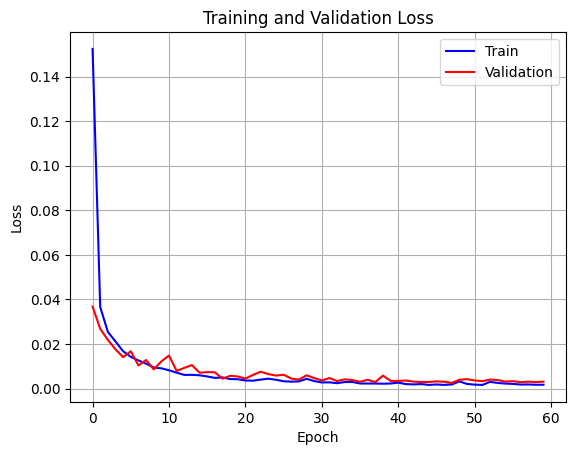

In [ ]:
# plot loss_epoch
plt.plot(range(total_epochs), loss_subset_train_hist, 'b-', label="Train")
plt.plot(range(total_epochs), loss_subset_valid_hist, 'r-', label="Validation")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

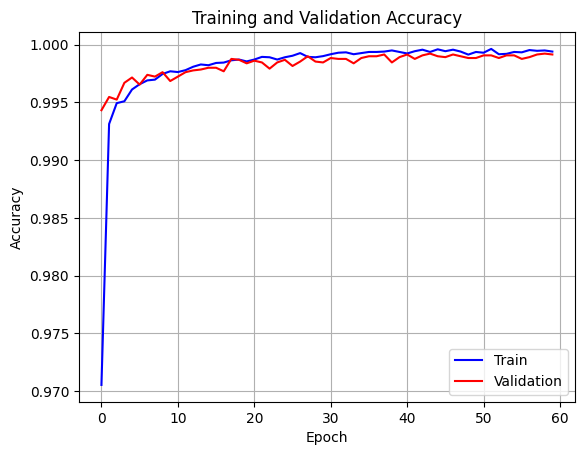

In [ ]:
# plot acc_epoch
plt.plot(range(total_epochs), acc_subset_train_hist, 'b-', label="Train")
plt.plot(range(total_epochs), acc_subset_valid_hist, 'r-', label="Validation")

plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()